# Tomographic Reconstruction: Total Variation regularization

Description: implementing  Total Variation (TV) regularized tomographic reconstruction using an ISTA-like optimization algorithm. It also mentions a comparison with a deep-learning-based unrolling method, for which external reconstructions are provided.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/checkpoints.zip
!mv checkpoints /content/drive/MyDrive

Archive:  /content/drive/MyDrive/checkpoints.zip
  inflating: checkpoints/LPD_0_180_angles30.pth  
  inflating: checkpoints/LPD_-30_30_angles30.pth  
  inflating: checkpoints/LPD_-15_15_angles30.pth  


In [ ]:
!unzip /content/drive/MyDrive/MayoDataset.zip
!mv Mayo_s\ Dataset MajoDataset

import os
import shutil
from PIL import Image

# path alla cartella MajoDataset 
root_dir = '/content/MajoDataset'

for split in ['train', 'test']:
    split_dir = os.path.join(root_dir, split)
    # scorri tutte le voci dentro train/ test
    for folder_name in os.listdir(split_dir):
        folder_path = os.path.join(split_dir, folder_name)
        if os.path.isdir(folder_path):
            # per ogni file nella sottocartella
            for fname in os.listdir(folder_path):
                src = os.path.join(folder_path, fname)
                # nuovo nome = nome della cartella + '_' + nome file
                new_fname = f"{folder_name}_{fname}"
                dst = os.path.join(split_dir, new_fname)
                # gestisci eventuali collisioni
                if os.path.exists(dst):
                    base, ext = os.path.splitext(new_fname)
                    i = 1
                    while True:
                        candidate = f"{base}_{i}{ext}"
                        candidate_path = os.path.join(split_dir, candidate)
                        if not os.path.exists(candidate_path):
                            dst = candidate_path
                            break
                        i += 1
                # sposta il file
                shutil.move(src, dst)

                # --- RESIZE DELL'IMMAGINE ---
                try:
                    with Image.open(dst) as img:
                        img = img.convert("RGB")  # garantiamo che sia RGB
                        img = img.resize((256, 256), Image.LANCZOS)
                        img.save(dst)
                except Exception as e:
                    print(f"Errore nel processare {dst}: {e}")

            # elimina la sottocartella vuota
            os.rmdir(folder_path)



Archive:  /content/drive/MyDrive/MayoDataset.zip
  inflating: Mayo_s Dataset/test/C081/307.png  
  inflating: Mayo_s Dataset/test/C081/303.png  
  inflating: Mayo_s Dataset/test/C081/321.png  
  inflating: Mayo_s Dataset/test/C081/315.png  
  inflating: Mayo_s Dataset/test/C081/300.png  
  inflating: Mayo_s Dataset/test/C081/290.png  
  inflating: Mayo_s Dataset/test/C081/314.png  
  inflating: Mayo_s Dataset/test/C081/288.png  
  inflating: Mayo_s Dataset/test/C081/301.png  
  inflating: Mayo_s Dataset/test/C081/323.png  
  inflating: Mayo_s Dataset/test/C081/322.png  
  inflating: Mayo_s Dataset/test/C081/312.png  
  inflating: Mayo_s Dataset/test/C081/298.png  
  inflating: Mayo_s Dataset/test/C081/316.png  
  inflating: Mayo_s Dataset/test/C081/310.png  
  inflating: Mayo_s Dataset/test/C081/309.png  
  inflating: Mayo_s Dataset/test/C081/313.png  
  inflating: Mayo_s Dataset/test/C081/308.png  
  inflating: Mayo_s Dataset/test/C081/318.png  
  inflating: Mayo_s Dataset/test/C081/3

In [4]:
!pip install https://github.com/devangelista2/IPPy/archive/master.zip
!pip install astra-toolbox torch torchvision torchaudio
!pip install torch_radon24

     - 38.7 kB 544.4 kB/s 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 130.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 108.9 MB/s eta 0:

## Section 1: Import Libraries

  Code Comment: This cell imports necessary Python libraries for numerical operations (NumPy), plotting (Matplotlib), file system operations (os), data manipulation (Pandas), and various image processing tasks from scikit-image, including Radon and inverse Radon transforms, resizing, phantom generation, and image quality metrics (PSNR, SSIM), as well as TV denoising.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pandas as pd
from skimage.transform import radon, iradon, resize
from skimage.data import shepp_logan_phantom
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import denoise_tv_chambolle
from PIL import Image
from IPPy.nn import models

from google.colab import drive
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

## Section 2: Helper functons

   Description: This section defines several helper functions that will be used throughout the notebook for tasks like error calculation, sinogram generation, and image reconstruction.

In [ ]:
import random
from torch_radon24 import Radon

def load_image_file(filepath, size=256):
    img = Image.open(filepath)
    if img.mode != 'L':
        img = img.convert('L')
    arr = np.array(img)
    resized = resize(arr, (size, size), anti_aliasing=True)
    return (resized - resized.min()) / (resized.max() - resized.min())

"""
def circular_mask(image):
    rows, cols = image.shape
    Y, X = np.ogrid[:rows, :cols]
    center = (rows/2, cols/2)
    radius = min(center)
    mask = (X-center[1])**2 + (Y-center[0])**2 <= radius**2
    return image * mask
"""

def generate_limited_angle_sinogram(image, num_angles, angle_range_deg,
                                     add_noise=False, noise_level=0.1):
    θ = np.linspace(angle_range_deg[0], angle_range_deg[1], num_angles, endpoint=True)
    sino = radon(image, theta=θ, circle=True)
    if add_noise:
        noise = np.random.normal(0, noise_level * sino.max(), sino.shape)
        sino = sino + noise
    return sino, θ

def tv_proximal_operator(image, weight):

    """
    Applies the Total Variation (TV) proximal operator, which is essentially TV denoising using the Chambolle algorithm.
    The weight parameter controls the strength of the denoising.
    """

    return denoise_tv_chambolle(image, weight=weight, channel_axis=None)

def tv_reconstruct_ista(sinogram, theta, lamda_tv, n_iter, image_shape=None, initial_reconstruction=None):
    step_size = 0.0005 
    for i in range(n_iter):
        projected = radon(reconstruction, theta=theta, circle=True)
        residual = projected - sinogram
        grad = iradon(residual, theta=theta, output_size=image_shape[0], filter_name=None, circle=False)
        update = reconstruction - step_size * grad
        reconstruction = tv_proximal_operator(update, weight=lamda_tv * step_size) # Chambolle denoising
        if (i + 1) % (n_iter // 5) == 0:
            projected_for_fidelity = radon(reconstruction, theta=theta, circle=True)
            fidelity = 0.5 * np.linalg.norm(projected_for_fidelity - sinogram)**2
            print(f"Iter {i+1}/{n_iter} - Data Fidelity: {fidelity:.4f}")

    return reconstruction

def relative_error(true, pred):

  """
  Calculates the Frobenius norm of the difference between the true and predicted images,
  normalized by the Frobenius norm of the true image.
  This gives a measure of the relative reconstruction error.
  """

  return np.linalg.norm(true - pred, 'fro') / np.linalg.norm(true, 'fro')






class MayoDataset(Dataset):
    def __init__(self, root_dir, split, geometry, num_angles,
                 add_noise=False, noise_level=0.01, image_size=256, isEvaluation = False):
        
        self.files       = sorted(glob.glob(os.path.join(root_dir, split, "*.png"))) 
        self.geometry    = geometry
        self.num_angles  = num_angles
        self.add_noise   = add_noise
        self.noise_level = noise_level
        self.image_size  = image_size
        self.isEvaluation = isEvaluation


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # 1) Ground truth (numpy array)
        img = load_image_file(self.files[idx], size=self.image_size) 

        # 2) Decidi se aggiungere rumore
        apply_noise_item = False
        if self.add_noise:
            apply_noise_item = (random.random() < 0.1) or self.isEvaluation 

        # 2) Sinogram (numpy array) e theta (numpy array in gradi)
        sinogram, theta_deg = generate_limited_angle_sinogram( 
            image             = img,
            num_angles        = self.num_angles,
            angle_range_deg   = self.geometry,
            add_noise         = apply_noise_item, 
            noise_level       = self.noise_level
        )

        img_t  = torch.tensor(img,      dtype=torch.float32).unsqueeze(0)  # (1,H,W)
        sino_t = torch.tensor(sinogram, dtype=torch.float32).unsqueeze(0)  # (1,Ndet,Na)

        # Restituisci theta (in gradi, come array numpy)
        return sino_t, img_t, theta_deg 




def composite_loss(pred, target, lambda_reg=0.01):
    # MSE normale
    mse = F.mse_loss(pred, target)

    # Calcolo della regolarizzazione TV
    # Assicura che pred sia 4D: (B, C, H, W)
    if pred.dim() == 3: # B,H,W -> B,1,H,W
        pred_4d = pred.unsqueeze(1)
    elif pred.dim() == 4:
        pred_4d = pred
    else: # Gestisci altri casi o solleva un errore
        raise ValueError(f"La previsione ha una dimensione inaspettata: {pred.dim()}")

    gradient_x = pred_4d[:, :, :, 1:] - pred_4d[:, :, :, :-1] # gradienti orizzontali
    gradient_y = pred_4d[:, :, 1:, :] - pred_4d[:, :, :-1, :] # gradienti verticali

    tv_x = torch.mean(torch.abs(gradient_x))
    tv_y = torch.mean(torch.abs(gradient_y))
    tv = tv_x + tv_y

    return mse + lambda_reg * tv


'''

class LearnedPrimalDualNet(nn.Module):
    def __init__(self, n_iter, dual_in_ch, primal_in_ch, ippy_cfg):
        super().__init__()
        self.n_iter = n_iter

        self.dual_nets = nn.ModuleList([
            models.UNet(
                ch_in=dual_in_ch*2,    # ora concateni due feature maps sinogram-size
                ch_out=dual_in_ch,
                **ippy_cfg
            ) for _ in range(n_iter)
        ])
        self.primal_nets = nn.ModuleList([
            models.UNet(
                ch_in=primal_in_ch*2,  # concateni due feature maps image-size
                ch_out=primal_in_ch,
                **ippy_cfg
            ) for _ in range(n_iter)
        ])

    def forward(self, sino, primal0):
        # sino:   [B,1,256,30]
        # primal0:[B,1,256,256]
        dual   = sino
        primal = primal0

        for i in range(self.n_iter):
            # 1) riduco primal allo stesso “spazio” di dual → [B,1,256,30]
            primal_ds = F.interpolate(primal,
                                      size=dual.shape[-2:],
                                      mode='bilinear',
                                      align_corners=False)

            # 2) dual‑update: concateni dual e primal_ds lungo il canale
            d_in = torch.cat([dual, primal_ds], dim=1)  # [B,2,256,30]
            dual = self.dual_nets[i](d_in)              # [B,1,256,30]

            # 3) riallargo dual allo spazio dell’immagine → [B,1,256,256]
            dual_us = F.interpolate(dual,
                                    size=primal.shape[-2:],
                                    mode='bilinear',
                                    align_corners=False)

            # 4) primal‑update: concateni primal e dual_us
            p_in = torch.cat([primal, dual_us], dim=1)  # [B,2,256,256]
            primal = self.primal_nets[i](p_in)          # [B,1,256,256]

        return primal
'''

'''
class LearnedPrimalDualNet(nn.Module):
    def __init__(self, n_iter, dual_in_ch, primal_in_ch, ippy_cfg):
        super().__init__()
        self.n_iter = n_iter

        self.dual_nets = nn.ModuleList([
            models.UNet(
                ch_in=dual_in_ch*2,
                ch_out=dual_in_ch,
                **ippy_cfg
            ) for _ in range(n_iter)
        ])
        self.primal_nets = nn.ModuleList([
            models.UNet(
                ch_in=primal_in_ch*2,
                ch_out=primal_in_ch,
                **ippy_cfg
            ) for _ in range(n_iter)
        ])

    def forward(self, sino, primal0, theta=None):
        # sino:   [B,1,Ndet,Na]  - sinogramma in input
        # primal0:[B,1,H,W]      - ricostruzione iniziale (tipicamente zeros)
        # theta:  array di angoli usati per generare il sinogramma

        dual = sino
        primal = primal0
        batch_size = sino.shape[0]

        for i in range(self.n_iter):
            # Implementa operatore di proiezione esplicito (Radon)
            # invece di interpolazione bilineare
            primal_proj_list = []
            for b in range(batch_size):
                # Estrai la singola immagine dal batch
                img = primal[b, 0].detach().cpu().numpy()

                # Applica l'operatore di Radon
                sino_proj = radon(img, theta=theta, circle=True)

                # Normalizza e converti in tensor
                sino_proj = torch.tensor(sino_proj, dtype=torch.float32).unsqueeze(0)
                primal_proj_list.append(sino_proj)

            # Stack dei risultati in un unico tensor
            primal_proj = torch.stack(primal_proj_list, dim=0).to(sino.device)

            # Dual update con operatore di Radon esplicito
            d_in = torch.cat([dual, primal_proj], dim=1)  # [B,2,Ndet,Na]
            dual = self.dual_nets[i](d_in)                # [B,1,Ndet,Na]

            # Implementa operatore di back-projection esplicito
            # invece di interpolazione bilineare
            dual_backproj_list = []
            for b in range(batch_size):
                # Estrai il sinogramma dal batch
                sino_b = dual[b, 0].detach().cpu().numpy()

                # Applica l'operatore di back-projection (iradon)
                img_backproj = iradon(sino_b, theta=theta, circle=True,
                                    output_size=primal.shape[2])

                # Normalizza e converti in tensor
                img_backproj = torch.tensor(img_backproj, dtype=torch.float32).unsqueeze(0)
                dual_backproj_list.append(img_backproj)

            # Stack dei risultati in un unico tensor
            dual_backproj = torch.stack(dual_backproj_list, dim=0).to(primal.device)

            # Primal update con operatore di back-projection esplicito
            p_in = torch.cat([primal, dual_backproj], dim=1)  # [B,2,H,W]
            primal = self.primal_nets[i](p_in)                # [B,1,H,W]

        return primal

'''
class LearnedPrimalDualNet(nn.Module):
    def __init__(self, n_iter, dual_in_ch, primal_in_ch, ippy_cfg):
        super().__init__()
        self.n_iter = n_iter

        self.dual_nets = nn.ModuleList([
            models.UNet(
                ch_in=dual_in_ch * 2,
                ch_out=dual_in_ch,
                **ippy_cfg
            ) for _ in range(n_iter)
        ])
        self.primal_nets = nn.ModuleList([
            models.UNet(
                ch_in=primal_in_ch * 2,
                ch_out=primal_in_ch,
                **ippy_cfg
            ) for _ in range(n_iter)
        ])

    def forward(self, sino, primal0, theta_np_rad): # theta_np_rad è un array NumPy di angoli in radianti
        dual = sino
        primal = primal0

        img_height, img_width = primal.shape[2], primal.shape[3] # H, W
        if img_height != img_width:
            print("Attenzione: LearnedPrimalDualNet (torch_radon24) si aspetta immagini quadrate.")

        current_device = primal.device

        # Inizializza gli operatori Radon.
        # 'thetas' si aspetta un array numpy di angoli in radianti.
        radon_projector = Radon(thetas=theta_np_rad,
                                circle=True, device=current_device,
                                filter_name=None) # Nessun filtro per la proiezione

        radon_backprojector = Radon(thetas=theta_np_rad,
                                    circle=True, device=current_device,
                                    filter_name=None) # NESSUN filtro FBP per la retroproiezione semplice

        for i in range(self.n_iter):
            # --- 1. Primal to Dual Space (Radon Transform) ---
           
            projected_primal = radon_projector.forward(primal)
           
            # --- 2. Dual Variable Update ---
           
            dual_update_input = torch.cat([dual, projected_primal], dim=1)
            dual = self.dual_nets[i](dual_update_input)

            # --- 3. Dual to Primal Space (Retroproiezione semplice) ---
           
            back_projected_dual = radon_backprojector.filter_backprojection(dual)
            

            # --- 4. Primal Variable Update ---
            primal_update_input = torch.cat([primal, back_projected_dual], dim=1)
            primal = self.primal_nets[i](primal_update_input)

        return primal


## Section 3: Defining parameters:

Description: This section initializes various parameters that will control the CT simulation and reconstruction process.

In [7]:
image_size = 256



lambda_tv_ista = 0.05
n_iterations_ista = 1000
num_angles = 30
noise_level = 0.1
geometries = [(-30, 30), (-15, 15), (0, 180)]
noise_flags = [False, True, False] #nella geometria -15 15 metto il flag noise a true (generera' rumore solo a 1/3 di immagini) per vedere poi in inferenza quanto sara' robusto al rumore


drive.mount('/content/drive')
CKPT_DIR = '/content/drive/MyDrive/checkpoints'
os.makedirs(CKPT_DIR, exist_ok=True)

# %% Parametri globali
batch_size       = 4
num_workers      = 2
pin_memory       = True

# %% Configurazione IPPy U‑Net
N_FEATURES             = 32
N_DUAL                 = 1
ippy_middle_ch         = [N_FEATURES, N_FEATURES * 2]
ippy_down_layers       = ["ResDownBlock"]
ippy_up_layers         = ["ResUpBlock"]
ippy_n_layers_per_block= 2

ippy_cfg = {
    'middle_ch':          ippy_middle_ch,
    'down_layers':        ippy_down_layers,
    'up_layers':          ippy_up_layers,
    'n_layers_per_block': ippy_n_layers_per_block
}

print("UNet config:", ippy_cfg)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
UNet config: {'middle_ch': [32, 64], 'down_layers': ['ResDownBlock'], 'up_layers': ['ResUpBlock'], 'n_layers_per_block': 2}


In [ ]:
# ------------------------------------
# |           TRAINING               |
# ------------------------------------

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as psnr
import time



# Parametri
N_ITER        = 10
primal_in_ch  = 1
epochs        = 50
max_batches   = 20   # solo per debugging
learning_rate = 1e-3


for geom, noise_flag in zip(geometries, noise_flags):


    print(f'traino la geometria {geom} con noise flag {noise_flag}')
    # --- Dataloader train e val ---
    train_ds = MayoDataset("/content/MajoDataset", "train", geom,
                           num_angles, noise_flag, noise_level, image_size)
    train_loader = DataLoader(train_ds, batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory, drop_last=True)

    val_ds = MayoDataset("/content/MajoDataset", "test", geom,
                         num_angles, noise_flag, noise_level, image_size)
    val_loader = DataLoader(val_ds, batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=pin_memory, drop_last=True)

    # --- Modello, ottim, loss ---
    net = LearnedPrimalDualNet(N_ITER, N_DUAL, primal_in_ch, ippy_cfg).cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
   

    # --- Preparazione checkpoint/resume ---
    ckpt_file = os.path.join(
        CKPT_DIR, f"LPD_{geom[0]}_{geom[1]}_angles{num_angles}.pth"
    )
    start_epoch    = 1
    best_psnr     = 0.0
    best_val_loss  = float('inf')
    if os.path.isfile(ckpt_file):
        ckpt = torch.load(ckpt_file)
        net.load_state_dict(ckpt['model'])
        optimizer.load_state_dict(ckpt['opt'])
        start_epoch   = ckpt['epoch'] + 1
        best_val_loss = ckpt['best_val_loss']
        best_psnr     = ckpt.get('best_psnr', 0.0)
        if 'scheduler' in ckpt:  
          scheduler.load_state_dict(ckpt['scheduler'])

        print(f">> Riprendo da epoca {start_epoch} con best_val_loss={best_val_loss:.4f}")

    theta_np_deg_fixed = np.linspace(geom[0], geom[1], num_angles, endpoint=True).astype(np.float32)
    theta_np_rad_fixed = np.deg2rad(theta_np_deg_fixed)

    # --- Loop epoche ---
    net.train()
    for epoch in range(start_epoch, epochs + 1):
        print(f'epoca {epoch}')
        total_loss = 0.0
        num_seen   = 0

        epoch_start = time.perf_counter()

        # TRAIN 
        for batch_idx, (sino, gt, theta_deg_batch_unused) in enumerate(train_loader):
            sino, gt = sino.cuda(), gt.cuda()
            primal0  = torch.zeros_like(gt)



            out = net(sino, primal0, theta_np_rad_fixed)
          
            loss = composite_loss(out, gt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bs = sino.size(0)
            total_loss += loss.item() * bs
            num_seen   += bs


            #if batch_idx + 1 >= max_batches:
            #    break

        train_loss = total_loss / num_seen
        print(f"[Train] Geom {geom}, Ep {epoch:02d}, Loss={train_loss:.4f}")

        # VALIDATION
        net.eval()
        val_loss_sum = 0.0
        val_psnr_sum = 0.0
        val_samples  = 0
        with torch.no_grad():
            for sino_v, gt_v, theta_v_deg_batch_unused  in val_loader:
                sino_v, gt_v = sino_v.cuda(), gt_v.cuda()
                primal0_v    = torch.zeros_like(gt_v)

                out_v = net(sino_v, primal0_v, theta_np_rad_fixed)
            
                l_v = composite_loss(out_v, gt_v)

                # Accumulo per la loss
                bs = sino_v.size(0)
                val_loss_sum += l_v.item() * bs

                # Calcolo PSNR su ciascun sample
                for b in range(bs):
                    rec_np = np.array(out_v[b,0].cpu().tolist(), dtype=np.float32)
                    gt_np  = np.array(gt_v[b,0].cpu().tolist(),     dtype=np.float32)
                    val_psnr_sum += psnr(gt_np, rec_np, data_range=1.0)
                    val_samples  += 1

        # Media
        val_loss = val_loss_sum / (val_samples)
        val_psnr = val_psnr_sum / val_samples

        epoch_time = time.perf_counter() - epoch_start
        print(f"[ Val ] Geom {geom}, Ep {epoch:02d}, ValLoss={val_loss:.4f}, ValPSNR={val_psnr:.2f}")

        minutes = int(epoch_time // 60)
        print(f"--> Tempo impiegato per epoca {epoch:02d}: {minutes} minuti")

        # Salva checkpoint se migliora
        is_best = val_loss < best_val_loss
        if is_best:
            best_val_loss = min(val_loss, best_val_loss)
            best_psnr     = max(val_psnr, best_psnr)

            torch.save({
                'epoch':         epoch,
                'model':         net.state_dict(),
                'opt':           optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'scheduler':     scheduler.state_dict(),
                'best_psnr':     best_psnr
            }, ckpt_file)
            print(f">> Nuovo best! Checkpoint salvato a epoca {epoch}")

        scheduler.step()
        net.train()

    print(f">> Fine training Geom {geom}. Best ValLoss={best_val_loss:.4f}, Best PSNR={best_psnr:.2f}\n")


traino la geometria (0, 180) con noise flag False
>> Riprendo da epoca 14 con best_val_loss=0.0073
epoca 14


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


[Train] Geom (0, 180), Ep 14, Loss=0.0034


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


[ Val ] Geom (0, 180), Ep 14, ValLoss=0.0076, ValPSNR=21.46
--> Tempo impiegato per epoca 14: 27 minuti
epoca 15


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


[Train] Geom (0, 180), Ep 15, Loss=0.0034


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


[ Val ] Geom (0, 180), Ep 15, ValLoss=0.0076, ValPSNR=21.50
--> Tempo impiegato per epoca 15: 27 minuti
epoca 16


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


[Train] Geom (0, 180), Ep 16, Loss=0.0033


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


[ Val ] Geom (0, 180), Ep 16, ValLoss=0.0089, ValPSNR=20.79
--> Tempo impiegato per epoca 16: 27 minuti
epoca 17


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


[Train] Geom (0, 180), Ep 17, Loss=0.0033


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


[ Val ] Geom (0, 180), Ep 17, ValLoss=0.0073, ValPSNR=21.61
--> Tempo impiegato per epoca 17: 27 minuti
epoca 18


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


[Train] Geom (0, 180), Ep 18, Loss=0.0031


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


[ Val ] Geom (0, 180), Ep 18, ValLoss=0.0073, ValPSNR=21.59
--> Tempo impiegato per epoca 18: 27 minuti
epoca 19


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


## Section 5: Evaluate results

Description: This section iterates through different CT geometries (angle ranges) and noise conditions. For each combination, it generates a sinogram, performs reconstructions using FBP and TV-ISTA, calculates image quality metrics (Relative Error, PSNR, SSIM), and displays the original image alongside the FBP and TV-ISTA reconstructions, both full and zoomed views. The resulting plots are saved as PNG files.

In [8]:
# Definiamo 4 diverse zone di zoom
zoom_coords_list = [
    (slice(70, 110), slice(130, 180)),
    (slice(80, 120), slice(80, 130)),
    (slice(145, 185), slice(100, 150))
]

N_ITER        = 10
primal_in_ch  = 1




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Iter 200/1000 - Data Fidelity: 3169.0200
Iter 400/1000 - Data Fidelity: 616.5826
Iter 600/1000 - Data Fidelity: 266.9905
Iter 800/1000 - Data Fidelity: 175.1567
Iter 1000/1000 - Data Fidelity: 140.5133
Saved plot: /content/drive/MyDrive/plots/plot_geom_0_180_no_noise.png
Iter 200/1000 - Data Fidelity: 90705.9573
Iter 400/1000 - Data Fidelity: 46528.5656
Iter 600/1000 - Data Fidelity: 32351.1587
Iter 800/1000 - Data Fidelity: 26600.2445
Iter 1000/1000 - Data Fidelity: 23940.4166
Saved plot: /content/drive/MyDrive/plots/plot_geom_0_180_noise.png


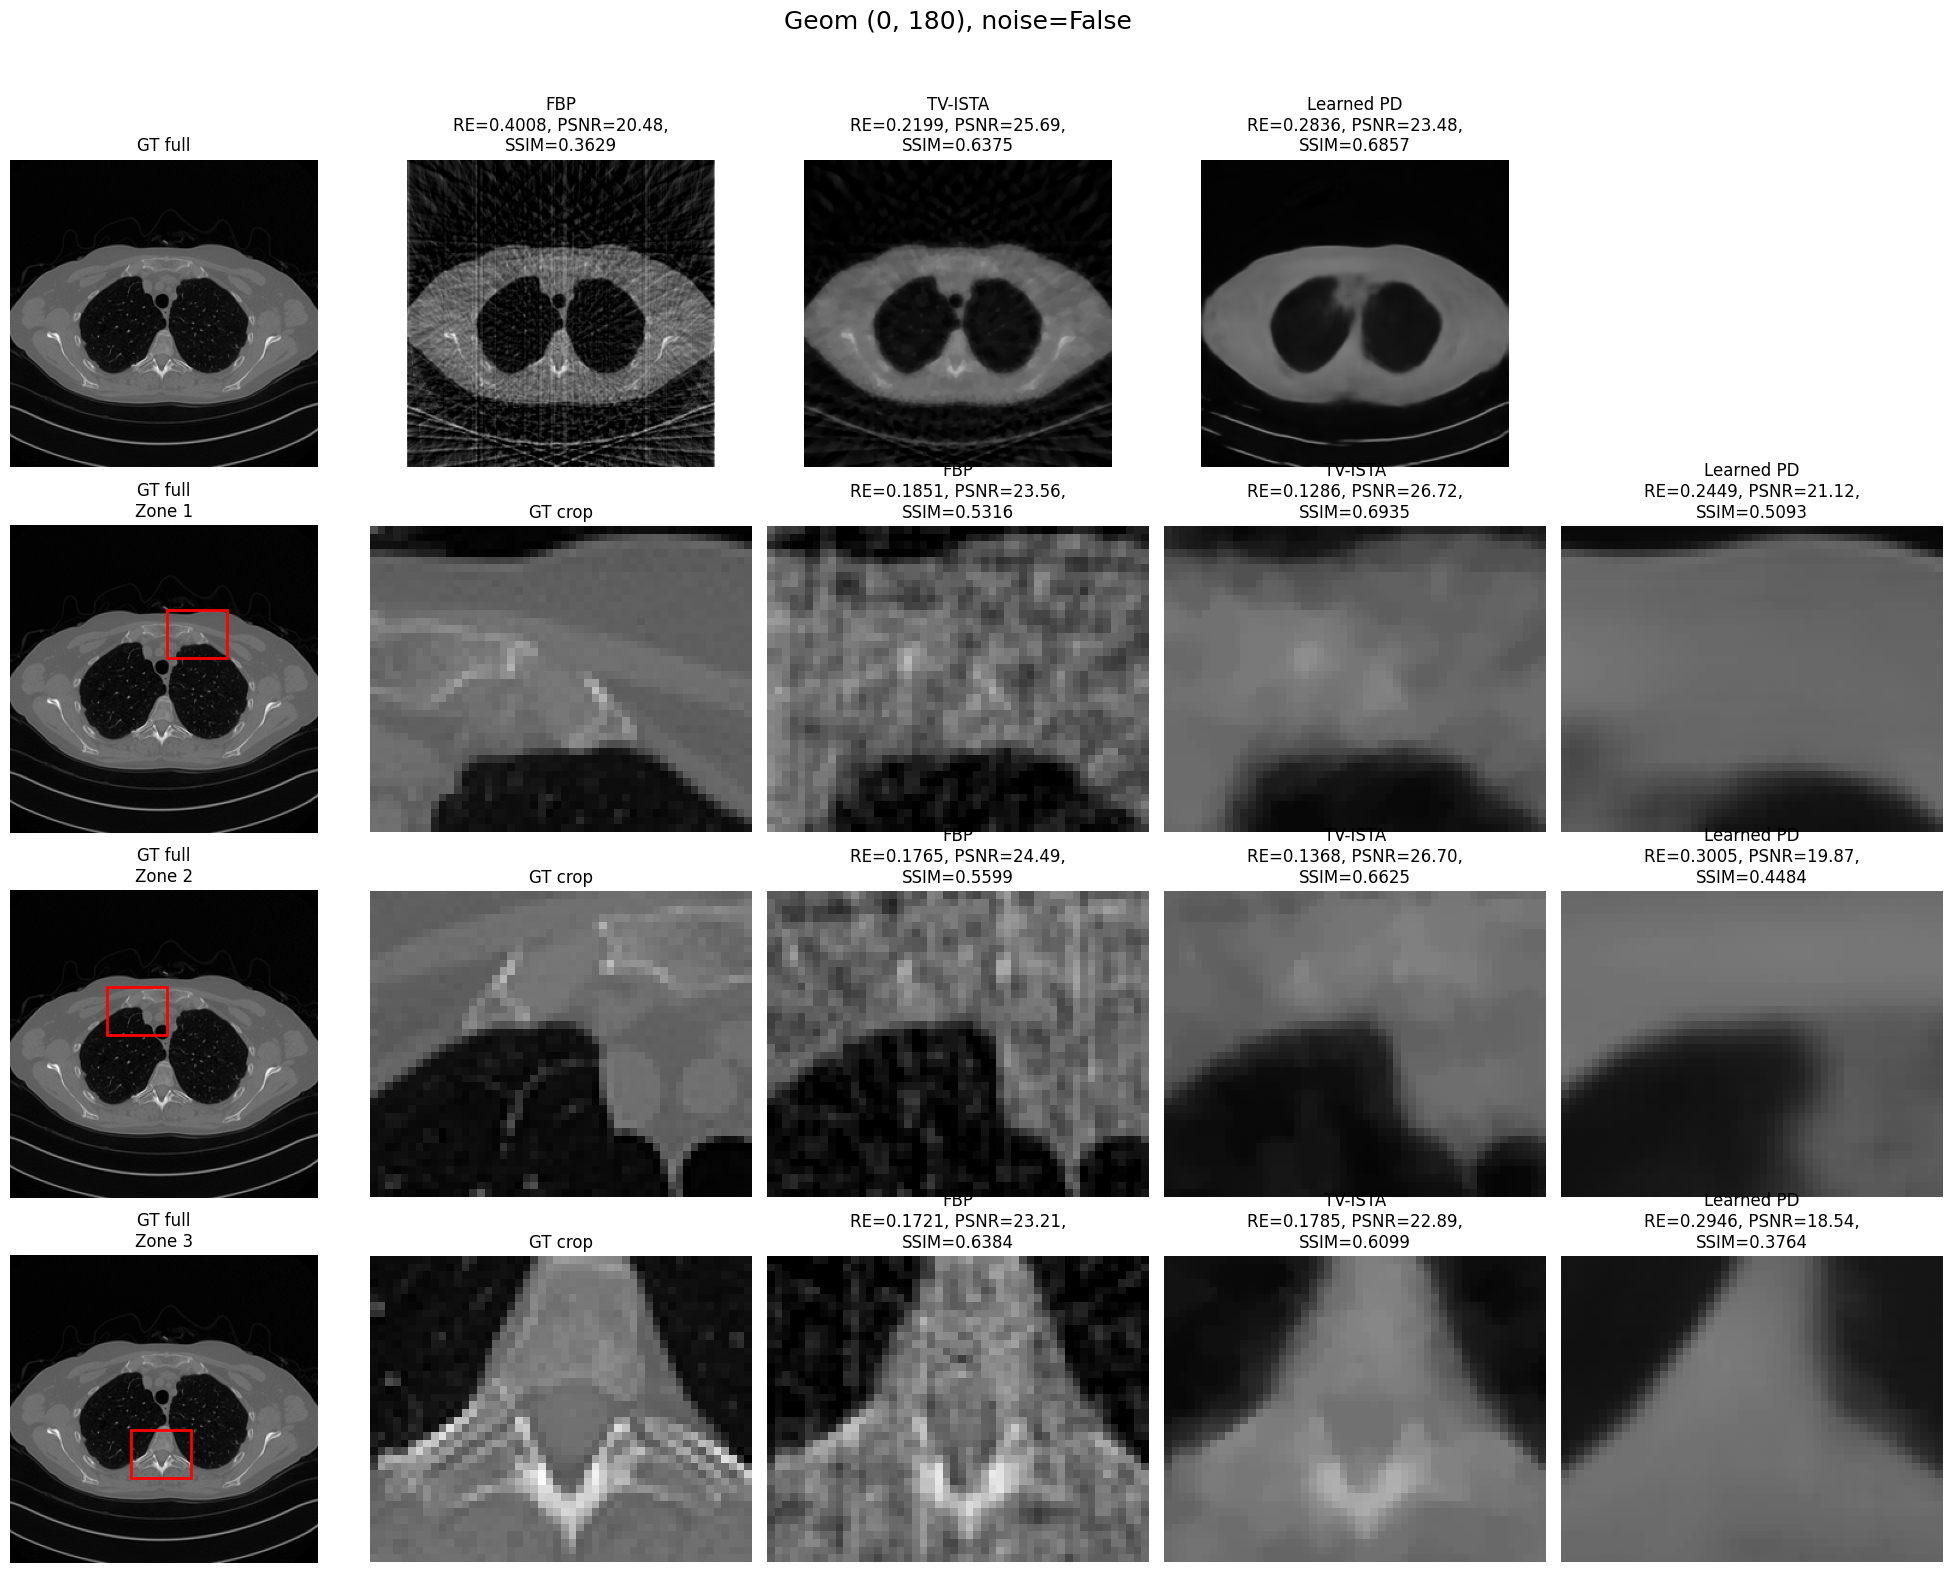

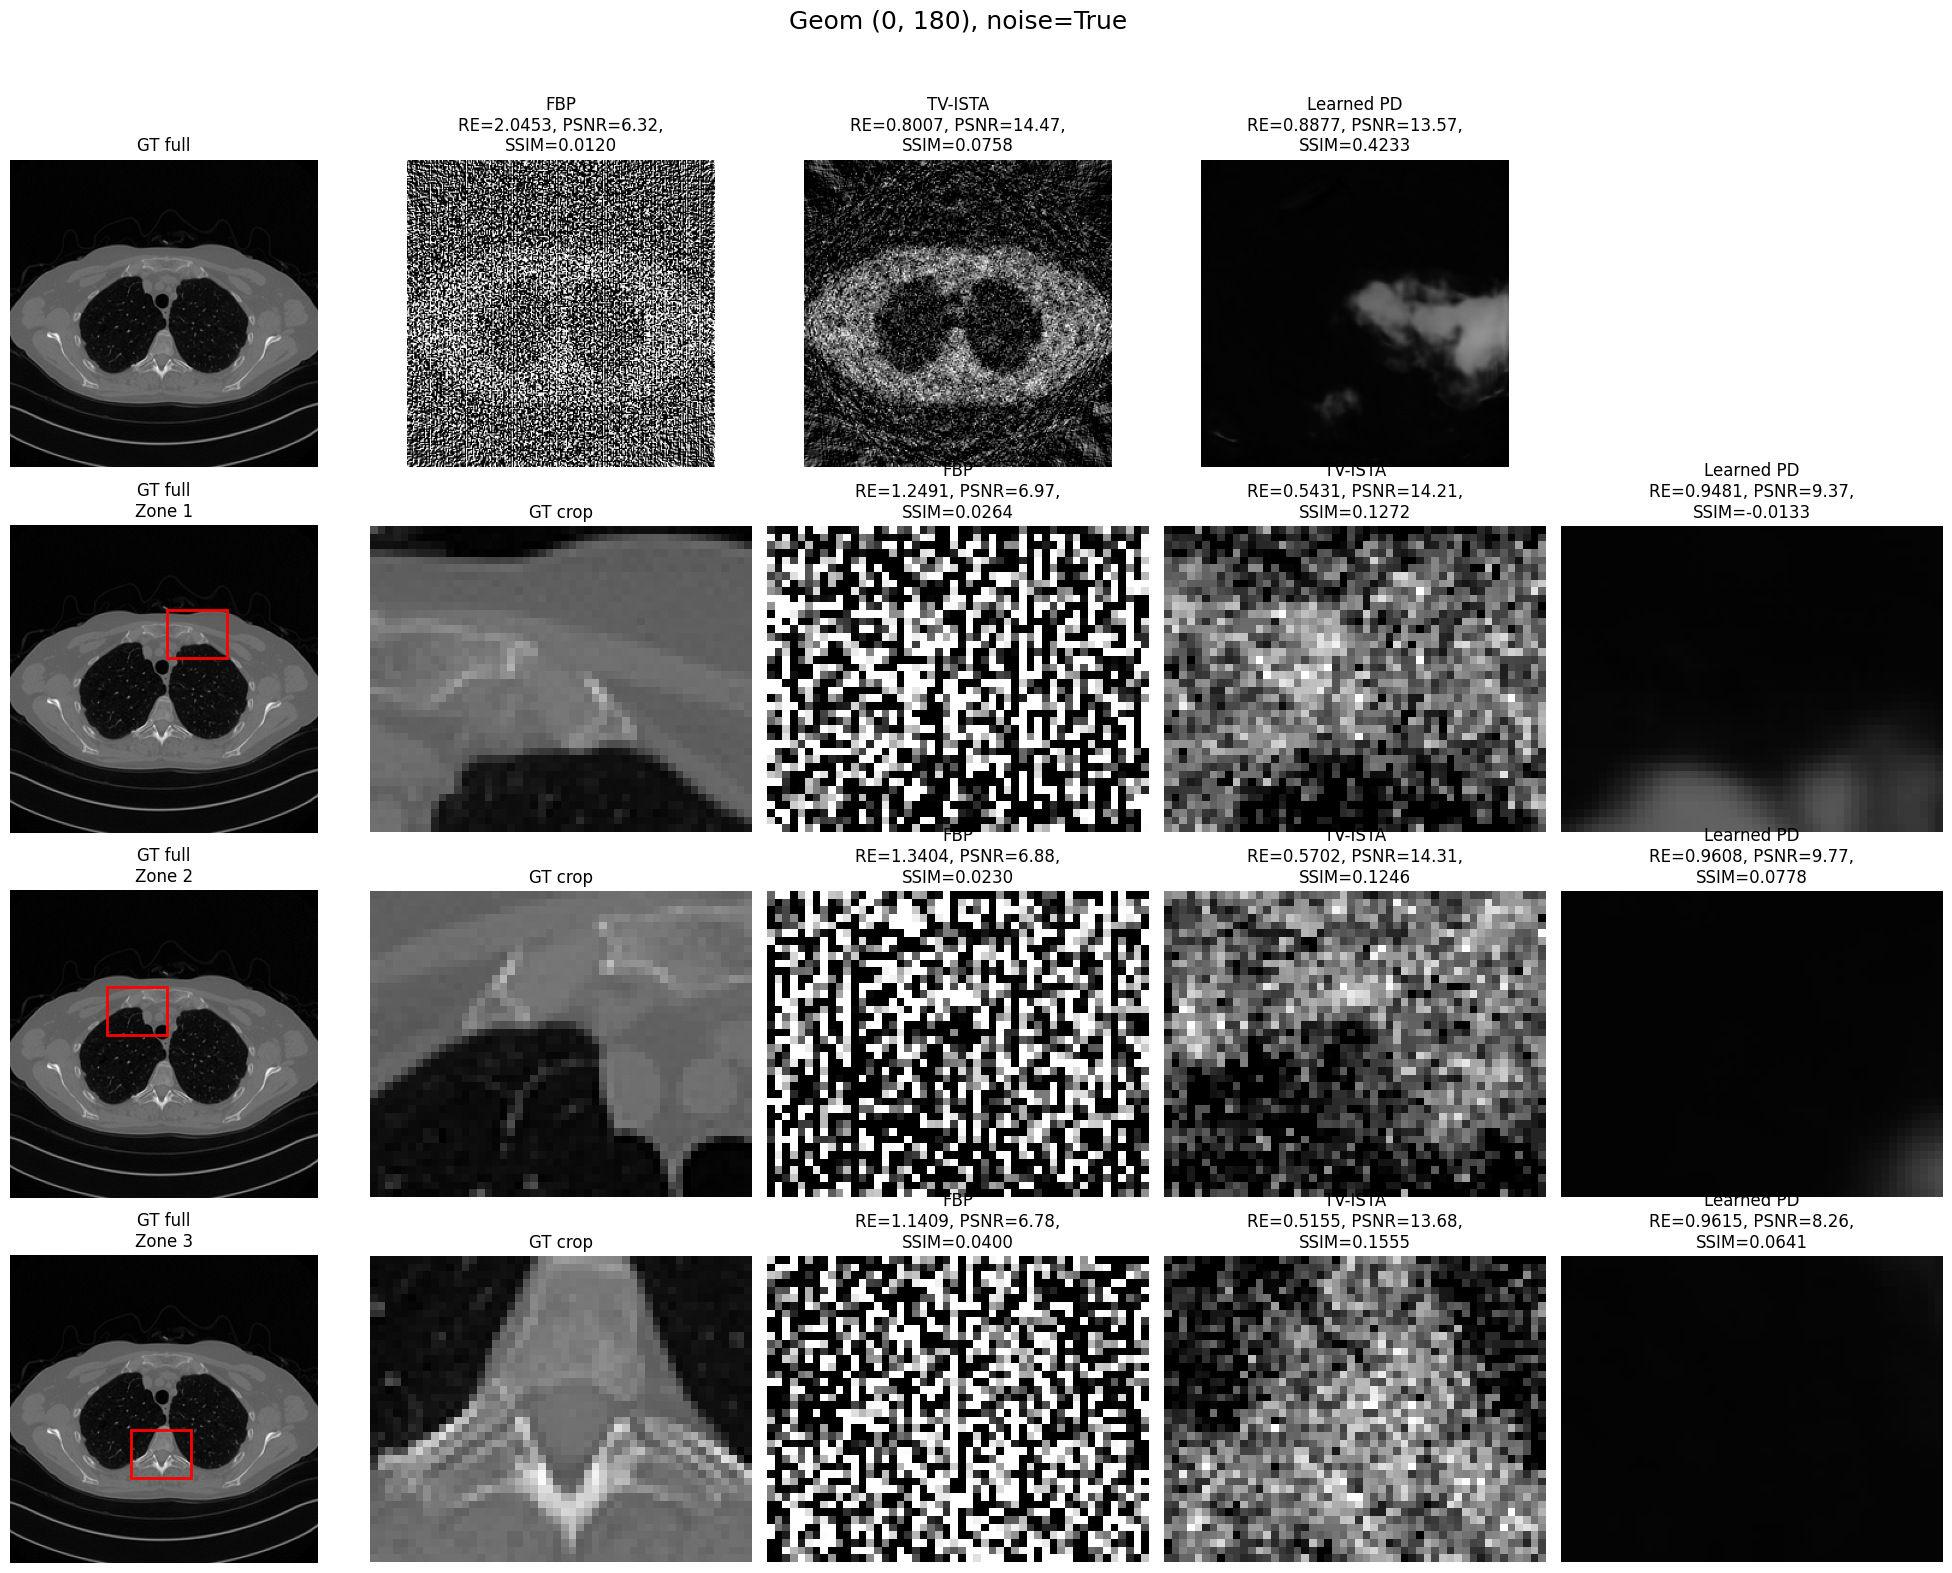

In [ ]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from itertools import product
import torch
from torch.utils.data import DataLoader

# Mount Google Drive
drive.mount('/content/drive')

# Directory to save plots
save_dir = '/content/drive/MyDrive/plots'
os.makedirs(save_dir, exist_ok=True)



for geom, noise_flag in product(geometries, [ False, True]):
    if geom == (-15, 15) or geom == (-30, 30):
      continue

    ckpt_file = os.path.join(
        CKPT_DIR, f"LPD_{geom[0]}_{geom[1]}_angles{num_angles}.pth"
    )



    # Load one sample for illustration

    test_ds = MayoDataset(
        root_dir    = "/content/MajoDataset",
        split       = "test",
        geometry    = geom,
        num_angles  = num_angles,
        add_noise   = noise_flag,
        noise_level = noise_level,
        image_size  = image_size,
        isEvaluation = True
    )
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)
    sino_t, img_t, theta_deg_batch  = next(iter(test_loader))
    sino_t, img_t = sino_t.cuda(), img_t.cuda()

    # Estrai l'array numpy degli angoli in gradi
    theta_np_deg = np.array(theta_deg_batch[0].cpu().tolist(), dtype=np.float32)
    # Converti in radianti per la rete
    theta_np_rad_for_net = np.deg2rad(theta_np_deg)

    net = LearnedPrimalDualNet(N_ITER, N_DUAL, primal_in_ch, ippy_cfg).cuda()

    ckpt = torch.load(ckpt_file)
    net.load_state_dict(ckpt['model'])
    net.eval()

    # Convert to numpy
    sino_np = np.array(sino_t[0,0].detach().cpu().tolist(), dtype=np.float32)
    orig_np = np.array(img_t[0,0].detach().cpu().tolist(), dtype=np.float32)


    # Reconstructions
    fbp = iradon(sino_np, theta=theta_np_deg, output_size=image_size,
                 filter_name='ramp', circle=False)
    
    fbp = np.clip(fbp, 0, 1)

    ista = tv_reconstruct_ista(
        sinogram               = sino_np,
        theta                  = theta_np_deg,
        lamda_tv               = lambda_tv_ista,
        n_iter                 = n_iterations_ista,
        image_shape            = orig_np.shape,
        initial_reconstruction = np.zeros(orig_np.shape)
    )
    ista = np.clip(ista, 0, 1)

    with torch.no_grad():
        out = net(sino_t, torch.zeros_like(img_t), theta_np_rad_for_net)
    lpd_np = np.clip(np.array(out[0,0].detach().cpu().tolist(), dtype=np.float32), 0, 1)

    recs = [orig_np, fbp, ista, lpd_np]
    methods = ["Ground Truth", "FBP", "TV-ISTA", "Learned PD"]

    # Plot full images + zoomed patches
    n_zoom = len(zoom_coords_list)
    fig, axs = plt.subplots(n_zoom + 1, 5, figsize=(20, 4*(n_zoom + 1)))

    # === Row 0: full images ===
    ax = axs[0, 0]
    ax.imshow(orig_np, cmap='gray', vmin=0, vmax=1)
    ax.set_title("GT full")
    ax.axis('off')

    for mi, (rec, method) in enumerate(zip(recs[1:], methods[1:]), start=1):
        re_full   = relative_error(orig_np, rec)
        psnr_full = psnr(orig_np, rec, data_range=1.0)
        ssim_full = ssim(orig_np, rec, data_range=1.0, channel_axis=None)

        ax = axs[0, mi]
        ax.imshow(rec, cmap='gray', vmin=0, vmax=1)
        ax.set_title(
            f"{method}\nRE={re_full:.4f}, PSNR={psnr_full:.2f},\nSSIM={ssim_full:.4f}"
        )
        ax.axis('off')

    # Blank last cell in row 0
    ax = axs[0, 4]
    ax.axis('off')

    # === Zoom rows ===
    for zi, zoom_coords in enumerate(zoom_coords_list, start=1):
        y_slice, x_slice = zoom_coords
        y0, y1 = y_slice.start, y_slice.stop
        x0, x1 = x_slice.start, x_slice.stop
        width, height = x1 - x0, y1 - y0

        # 1) Full GT with red rectangle
        ax = axs[zi, 0]
        ax.imshow(orig_np, cmap='gray', vmin=0, vmax=1)
        rect = Rectangle((x0, y0), width, height,
                         edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)
        ax.set_title(f"GT full\nZone {zi}")
        ax.axis('off')

        # 2) GT crop
        gt_crop = orig_np[zoom_coords]
        ax = axs[zi, 1]
        ax.imshow(gt_crop, cmap='gray', vmin=0, vmax=1)
        ax.set_title("GT crop")
        ax.axis('off')

        # 3–5) reconstructions crop + metrics
        for mi, (rec, method) in enumerate(zip(recs[1:], methods[1:]), start=2):
            crop = rec[zoom_coords]
            re_z   = relative_error(gt_crop, crop)
            psnr_z = psnr(gt_crop, crop, data_range=1.0)
            ssim_z = ssim(gt_crop, crop, data_range=1.0, channel_axis=None)

            ax = axs[zi, mi]
            ax.imshow(crop, cmap='gray', vmin=0, vmax=1)
            ax.set_title(
                f"{method}\nRE={re_z:.4f}, PSNR={psnr_z:.2f},\nSSIM={ssim_z:.4f}"
            )
            ax.axis('off')

    fig.suptitle(f"Geom {geom}, noise={noise_flag}", fontsize=18)
    plt.tight_layout(rect=[0,0,1,0.96])

    # Save figure to Drive
    geom_str = f"{int(geom[0])}_{int(geom[1])}"
    noise_str = 'noise' if noise_flag else 'no_noise'
    filename = f"plot_geom_{geom_str}_{noise_str}.png"
    filepath = os.path.join(save_dir, filename)
    fig.savefig(filepath, dpi=300, bbox_inches='tight')

    print(f"Saved plot: {filepath}")


In [ ]:
import pandas as pd
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import torch
from torch.utils.data import DataLoader
from itertools import product


# Parametri generali
MAX_SAMPLES_PER_CONDITION = 20
methods = ["FBP", "TV-ISTA", "Learned PD"]
metric_names = ["RE", "PSNR", "SSIM"]
zones = ["Full"] + [f"Zoom{i+1}" for i in range(len(zoom_coords_list))]

ckpt_file = os.path.join(
        CKPT_DIR, f"LPD_{geom[0]}_{geom[1]}_angles{num_angles}.pth"
    )

# Lista per raccogliere tutte le righe finali
all_table_rows = []

net.eval()

# Loop su tutte le combinazioni (4 condizioni)
for geom, noise_flag in product(geometries, [False, True]):
    if geom == (-15, 15) or geom == (-30, 30):
          continue

    geom_str = f"{abs(geom[0])}-{abs(geom[1])}"
    noise_str = "TRUE" if noise_flag else "FALSE"

    # Inizializza dizionario metriche per questa condizione
    metrics = {m: {z: {k: [] for k in metric_names} for z in zones} for m in methods}

    test_ds = MayoDataset(
        root_dir    = "/content/MajoDataset",
        split       = "test",
        geometry    = geom,
        num_angles  = num_angles,
        add_noise   = noise_flag,
        noise_level = noise_level,
        image_size  = image_size,
        isEvaluation = True
    )
    test_loader = DataLoader(
        test_ds,
        batch_size = 1,
        shuffle    = False,
        num_workers= num_workers,
        pin_memory = pin_memory
    )



    sample_count = 0
    for sino_t, img_t, theta_deg_batch in test_loader:
        if sample_count >= MAX_SAMPLES_PER_CONDITION:
            break
        sample_count += 1

        # Estrai l'array numpy degli angoli in gradi 
        theta_np_deg = np.array(theta_deg_batch[0].cpu().tolist(), dtype=np.float32)
        # Converti in radianti per la rete
        theta_np_rad_for_net = np.deg2rad(theta_np_deg)

        sino_t, img_t = sino_t.cuda(), img_t.cuda()
        sino_np = np.array(sino_t[0,0].detach().cpu().tolist(), dtype=np.float32)
        orig_np = np.array(img_t[0,0].detach().cpu().tolist(), dtype=np.float32)

        net = LearnedPrimalDualNet(N_ITER, N_DUAL, primal_in_ch, ippy_cfg).cuda()

        ckpt = torch.load(ckpt_file)
        net.load_state_dict(ckpt['model'])

        # FBP
        fbp = iradon(sino_np, theta=theta_np_deg, output_size=image_size,
                     filter_name='ramp', circle=False)
        fbp = np.clip(fbp, 0, 1)

        # TV‑ISTA
        ista = tv_reconstruct_ista(
            sinogram               = sino_np,
            theta                  = theta_np_deg,
            lamda_tv               = lambda_tv_ista,
            n_iter                 = n_iterations_ista,
            image_shape            = orig_np.shape,
            initial_reconstruction = np.zeros(orig_np.shape)
        )
        ista = np.clip(ista, 0, 1)

        # Learned Primal‑Dual
        with torch.no_grad():
            out = net(sino_t, torch.zeros_like(img_t), theta_np_rad_for_net)
        lpd_np = np.array(out[0,0].detach().cpu().tolist(), dtype=np.float32)
        lpd_np = np.clip(lpd_np, 0, 1)

        # Lista di ricostruzioni e metodi
        recs = [fbp, ista, lpd_np]
        for rec, method in zip(recs, methods):
            # Full metrics
            re_val   = relative_error(orig_np, rec)
            psnr_val = psnr(orig_np, rec, data_range=1.0)
            ssim_val = ssim(orig_np, rec, data_range=1.0, channel_axis=None)

            metrics[method]["Full"]["RE"].append(re_val)
            metrics[method]["Full"]["PSNR"].append(psnr_val)
            metrics[method]["Full"]["SSIM"].append(ssim_val)

            # Zoom metrics
            for i, zoom_coords in enumerate(zoom_coords_list):
                gt_crop  = orig_np[zoom_coords]
                rec_crop = rec[zoom_coords]

                re_z   = relative_error(gt_crop, rec_crop)
                psnr_z = psnr(gt_crop, rec_crop, data_range=1.0)
                ssim_z = ssim(gt_crop, rec_crop, data_range=1.0, channel_axis=None)

                zone_name = f"Zoom{i+1}"
                metrics[method][zone_name]["RE"].append(re_z)
                metrics[method][zone_name]["PSNR"].append(psnr_z)
                metrics[method][zone_name]["SSIM"].append(ssim_z)

    # Costruzione righe tabella per questa condizione
    for method in methods:
        row = {
            "Method": method,
            "Geometry": geom_str,
            "Noise": noise_str,
            "N Samples": sample_count
        }
        for zone in zones:
            for metric in metric_names:
                values = metrics[method][zone][metric]
                mean_val = np.mean(values)
                if metric == "PSNR":
                    row[f"{metric} ({zone})"] = f"{mean_val:.2f}"
                else:
                    row[f"{metric} ({zone})"] = f"{mean_val:.4f}"
        all_table_rows.append(row)

# Crea DataFrame unico
df_all = pd.DataFrame(all_table_rows)

# Stampa a schermo
print(df_all.to_string(index=False))

# Salva su Google Drive
output_filename = "/content/drive/MyDrive/metrics_summary_all_conditions.xlsx"
df_all.to_excel(output_filename, index=False)
print(f"\nTabella salvata in file: {output_filename}")


Iter 200/1000 - Data Fidelity: 3169.0200
Iter 400/1000 - Data Fidelity: 616.5826
Iter 600/1000 - Data Fidelity: 266.9905
Iter 800/1000 - Data Fidelity: 175.1567
Iter 1000/1000 - Data Fidelity: 140.5133
Iter 200/1000 - Data Fidelity: 2263.4434
Iter 400/1000 - Data Fidelity: 479.3029
Iter 600/1000 - Data Fidelity: 220.0531
